We consider a simple fluid of particles that interact due to the Lennard Jones potential

$$
U(r) = 4\varepsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]
$$

To validate the integration of the diffusion process and correct implementation of energies and forces, we compare observables to results from the literature. The observables are: the mean potential energy of the system per particle $U$,  the pressure $P$ and the radial distribution function $g(r)$.

The thermodynamic quantities of a Lennard Jones fluid are typically expressed in terms of the rescaled density
$\rho^* = (N/V)\sigma^3$ and the rescaled temperature $T^* = k_BT/\varepsilon$, where $N$ is the number of particles in the system, which is constant over time, and $V$ is the available volume.
In simulation practice we set $\sigma=1$ and $\varepsilon=1$ to achieve the reduced units. The quantity $\sigma^2 / 4D$ gives rise to a typical time scale, where $D$ is the self diffusion coefficient of the particles. In practice we set the diffusion coefficient to 1.

We use an Euler-Maruyama scheme to integrate the positions of particles according to the overdamped Langevin equation of motion, in contrast to an integration of positions and momenta in the underdamped limit.

The pressure can be measured from the acting forces according to [4]

$$
PV = Nk_BT + \langle \mathscr{W} \rangle
$$

where

$$
\mathscr{W} = \frac{1}{3} \sum_i \sum_{j>i} \mathbf{r}_{ij} \mathbf{f}_{ij},
$$

is the virial that describes the deviation from ideal-gas-behavior. It is measured in terms of pairwise acting forces $\mathbf{f}_{ij}$ between particles $i$ and $j$ which are separated by $\mathbf{r}_{ij}$. This is implemented by ReaDDy's pressure observable.

__Results__

| origin | cutoff radius $r_c$ | density $\rho$ | temperature $T$ | pressure $P$ | potential energy per particle $U$ |
|---|---|---|---|---|---|
|[1]|4|0.3|3|1.023(2)|-1.673(2)|
|[2]|4|0.3|3|1.0245|-1.6717|
|HALMD [3]|4|0.3|3|1.0234(3)|-1.6731(4)|
|ReaDDy|4|0.3|3|1.035(7)|-1.679(3)|
|||||||
|[1]|4|0.6|3|3.69(1)|-3.212(3)|
|[2]|4|0.6|3|3.7165|-3.2065|
|HALMD [3]|4|0.6|3|3.6976(8)|-3.2121(2)|
|ReaDDy|4|0.6|3|3.70(2)|-3.208(7)|

[1] Molecular dynamics simulations, J. K. Johnson, J. A. Zollweg, and K. E. Gubbins,
The Lennard-Jones equation of state revisited, Mol. Phys. 78, 591 (1993)

[2] Integral equations theory, A. Ayadim, M. Oettel, and S Amokrane,
Optimum free energy in the reference functional approach for the integral equations theory, J. Phys.: Condens. Matter 21, 115103 (2009).

[3] HAL's MD package, http://halmd.org/validation.html

[4] Allen, M. P., & Tildesley, D. J. (1987). Computer Simulation of Liquids. New York: Oxford University Press.

In [1]:
import os
import numpy as np

import readdy
print(readdy.__version__)

v2.0.3-27


Utility methods

In [2]:
def average_across_first_axis(values):
    n_values = len(values)
    mean = np.sum(values, axis=0) / n_values  # shape = n_bins
    difference = values - mean  # broadcasting starts with last axis
    std_dev = np.sqrt(np.sum(difference * difference, axis=0) / n_values)
    std_err = np.sqrt(np.sum(difference * difference, axis=0) / n_values ** 2)
    return mean, std_dev, std_err


def lj_system(edge_length, temperature=1.):
    system = readdy.ReactionDiffusionSystem(
        box_size=[edge_length, edge_length, edge_length],
        unit_system=None
    )
    system.kbt = temperature
    system.add_species("A", diffusion_constant=1.)
    system.potentials.add_lennard_jones("A", "A", m=12, n=6, epsilon=1., sigma=1., cutoff=4., shift=True)
    return system

Wrap the whole simulation and analysis in a function and perform it for the two densities 0.3 and 0.6.

In [3]:
def equilibrate_and_measure(density=0.3):
    n_per_axis = 12
    n_particles = n_per_axis ** 3
    edge_length = (n_particles / density) ** (1. / 3.)
    pos_x = np.linspace(-edge_length/2., edge_length/2.-1., n_per_axis)
    pos = []
    for x in pos_x:
        for y in pos_x:
            for z in pos_x:
                pos.append([x,y,z])
    pos = np.array(pos)
    print("n_particles", len(pos), "box edge_length", edge_length)
    assert len(pos)==n_particles
    
    def pos_callback(x):
        nonlocal pos
        n = len(x)
        pos = np.zeros((n,3))
        for i in range(n):
            pos[i][0] = x[i][0]
            pos[i][1] = x[i][1]
            pos[i][2] = x[i][2]
        print("saved positions")
    
    # create system
    system = lj_system(edge_length, temperature=3.)
    
    # equilibrate
    sim = system.simulation(kernel="CPU")
    sim.add_particles("A", pos)

    sim.observe.particle_positions(2000, callback=pos_callback, save=None)
    sim.observe.energy(500, callback=lambda x: print(x), save=None)

    sim.record_trajectory(stride=1)
    sim.output_file = "lj_eq.h5"
    if os.path.exists(sim.output_file):
        os.remove(sim.output_file)

    sim.run(n_steps=10000, timestep=1e-4)

    traj = readdy.Trajectory(sim.output_file)
    traj.convert_to_xyz(particle_radii={"A": 0.5})
    
    # measure
    sim = system.simulation(kernel="CPU")
    sim.add_particles("A", pos)
    sim.observe.energy(200)
    sim.observe.pressure(200)
    sim.observe.rdf(
        200, bin_borders=np.linspace(0.5, 4., 50),
        types_count_from="A", types_count_to="A", particle_to_density=density)

    sim.output_file = "lj_measure.h5"
    if os.path.exists(sim.output_file):
        os.remove(sim.output_file)

    sim.run(n_steps=10000, timestep=1e-4)
    
    # obtain results
    traj = readdy.Trajectory(sim.output_file)
    _, energy = traj.read_observable_energy()
    _, bin_centers, rdf = traj.read_observable_rdf()
    _, pressure = traj.read_observable_pressure()
    
    energy_mean, _, energy_err = average_across_first_axis(energy) # time average
    energy_mean /= n_particles
    energy_err /= n_particles

    pressure_mean, _, pressure_err = average_across_first_axis(pressure) # time average

    rdf_mean, _, rdf_err = average_across_first_axis(rdf) # time average

    return {
        "energy_mean": energy_mean, "energy_err": energy_err,
        "pressure_mean": pressure_mean, "pressure_err": pressure_err,
        "rdf_mean": rdf_mean, "rdf_err": rdf_err, "rdf_bin_centers": bin_centers
    }

In [4]:
result_low_dens = equilibrate_and_measure(density=0.3)

  0%|          | 0/1000 [00:00<?, ?it/s]

n_particles 1728 box edge_length 17.925618986228656
Configured kernel context with:
--------------------------------
 - kBT = 3.0
 - periodic b.c. = (true, true, true)
 - box size = (17.9256, 17.9256, 17.9256)
 - particle types:
     *  particle type "A" with D=1.0
 - potentials of order 2:
     * for types "A" and "A"
         * 12.0-6.0-Lennard-Jones potential with cutoff=4.0, epsilon=1.0, k=4.0, and with energy shift

Configured simulation loop with:
--------------------------------
 - timeStep = 0.000100000
 - evaluateObservables = true
 - progressOutputStride = 100
 - context written to file = true
 - Performing actions:
   * Initialize neighbor list? true
   * Update neighbor list? true
   * Clear neighbor list? true
   * Integrate diffusion? true
   * Calculate forces? true
   * Handle reactions? true
   * Handle topology reactions? true

saved positions
-2006.092638276083


  5%|▌         | 50/1000 [00:16<05:38,  2.81it/s]

-2663.1424920832724


 10%|█         | 100/1000 [00:32<05:05,  2.95it/s]

-2759.8158335119415


 15%|█▌        | 150/1000 [00:48<04:22,  3.24it/s]

-2769.480985654246


 20%|██        | 200/1000 [01:02<03:31,  3.78it/s]

saved positions
-2758.3520150659533


 25%|██▌       | 250/1000 [01:15<03:08,  3.97it/s]

-2838.185778357589


 30%|███       | 300/1000 [01:29<03:00,  3.89it/s]

-2841.100358293537


 35%|███▌      | 350/1000 [01:43<02:51,  3.79it/s]

-2801.9811061164173


 40%|████      | 400/1000 [01:57<02:44,  3.66it/s]

saved positions
-2865.1272257328483


 45%|████▌     | 450/1000 [02:11<02:37,  3.49it/s]

-2891.940879474006


 50%|█████     | 500/1000 [02:26<02:25,  3.43it/s]

-2824.1108673381364


 55%|█████▌    | 550/1000 [02:41<02:13,  3.38it/s]

-2930.0205689454847


 60%|██████    | 600/1000 [02:55<01:55,  3.46it/s]

saved positions
-2901.9845693204093


 65%|██████▌   | 650/1000 [03:10<01:46,  3.28it/s]

-2861.9925088341834


 70%|███████   | 700/1000 [03:25<01:33,  3.21it/s]

-2829.326983694836


 75%|███████▌  | 750/1000 [03:41<01:16,  3.26it/s]

-2874.095379626244


 80%|████████  | 800/1000 [03:57<01:04,  3.09it/s]

saved positions
-2918.8710282053125


 85%|████████▌ | 850/1000 [04:13<00:47,  3.14it/s]

-2809.1883820136936


 90%|█████████ | 900/1000 [04:28<00:30,  3.25it/s]

-2862.796625209495


 95%|█████████▌| 950/1000 [04:45<00:15,  3.15it/s]

-2996.5870985783413


100%|██████████| 1000/1000 [05:01<00:00,  3.32it/s]

saved positions
-2969.2603788072392



  0%|          | 0/1000 [00:00<?, ?it/s]

Configured kernel context with:
--------------------------------
 - kBT = 3.0
 - periodic b.c. = (true, true, true)
 - box size = (17.9256, 17.9256, 17.9256)
 - particle types:
     *  particle type "A" with D=1.0
 - potentials of order 2:
     * for types "A" and "A"
         * 12.0-6.0-Lennard-Jones potential with cutoff=4.0, epsilon=1.0, k=4.0, and with energy shift

Configured simulation loop with:
--------------------------------
 - timeStep = 0.000100000
 - evaluateObservables = true
 - progressOutputStride = 100
 - context written to file = true
 - Performing actions:
   * Initialize neighbor list? true
   * Update neighbor list? true
   * Clear neighbor list? true
   * Integrate diffusion? true
   * Calculate forces? true
   * Handle reactions? true
   * Handle topology reactions? true



100%|██████████| 1000/1000 [05:45<00:00,  2.89it/s]


In [5]:
result_low_dens

{'energy_mean': -1.6663065999844973,
 'energy_err': 0.004068511442129084,
 'pressure_mean': 1.0241356362812084,
 'pressure_err': 0.007471245837546726,
 'rdf_mean': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.73771465e-04, 1.42643258e-01, 7.90076755e-01, 1.37058562e+00,
        1.48700339e+00, 1.40774728e+00, 1.26934966e+00, 1.17417650e+00,
        1.09760049e+00, 1.03248774e+00, 1.00018151e+00, 9.77339310e-01,
        9.52078308e-01, 9.54373365e-01, 9.58670740e-01, 9.78288430e-01,
        9.85144126e-01, 9.96332472e-01, 9.96971138e-01, 1.01546690e+00,
        1.00858485e+00, 1.01263937e+00, 1.00667808e+00, 1.00287432e+00,
        1.00332166e+00, 1.00407493e+00, 1.00003326e+00, 9.97703466e-01,
        1.00256106e+00, 1.00126730e+00, 1.00149326e+00, 9.99601950e-01,
        9.99207132e-01, 1.00320129e+00, 1.00385635e+00, 1.00234372e+00,
        1.00496500e+00, 9.96759322e-01, 1.00211504e+00, 1.00032322e+00,
        9.97838840e-01, 1.00435081e+00, 1.000

In [6]:
result_hi_dens = equilibrate_and_measure(density=0.6)

  0%|          | 0/1000 [00:00<?, ?it/s]

n_particles 1728 box edge_length 14.227573217960249
Configured kernel context with:
--------------------------------
 - kBT = 3.0
 - periodic b.c. = (true, true, true)
 - box size = (14.2276, 14.2276, 14.2276)
 - particle types:
     *  particle type "A" with D=1.0
 - potentials of order 2:
     * for types "A" and "A"
         * 12.0-6.0-Lennard-Jones potential with cutoff=4.0, epsilon=1.0, k=4.0, and with energy shift

Configured simulation loop with:
--------------------------------
 - timeStep = 0.000100000
 - evaluateObservables = true
 - progressOutputStride = 100
 - context written to file = true
 - Performing actions:
   * Initialize neighbor list? true
   * Update neighbor list? true
   * Clear neighbor list? true
   * Integrate diffusion? true
   * Calculate forces? true
   * Handle reactions? true
   * Handle topology reactions? true

saved positions
-6881.589189751791


  5%|▌         | 50/1000 [01:03<19:58,  1.26s/it]

-5551.336656562339


 10%|█         | 100/1000 [02:07<18:26,  1.23s/it]

-5517.792907415611


 15%|█▌        | 150/1000 [03:10<18:16,  1.29s/it]

-5578.622215635525


 20%|██        | 200/1000 [04:15<17:41,  1.33s/it]

saved positions
-5565.460833824768


 25%|██▌       | 250/1000 [05:19<16:23,  1.31s/it]

-5530.96678538631


 30%|███       | 300/1000 [06:22<14:44,  1.26s/it]

-5748.91818758591


 35%|███▌      | 350/1000 [07:27<14:08,  1.31s/it]

-5522.570473647219


 40%|████      | 400/1000 [08:31<12:17,  1.23s/it]

saved positions
-5427.976867616478


 45%|████▌     | 450/1000 [09:40<13:40,  1.49s/it]

-5404.535270232334


 50%|█████     | 500/1000 [10:53<11:03,  1.33s/it]

-5425.220376798604


 55%|█████▌    | 550/1000 [11:57<10:02,  1.34s/it]

-5598.445519678548


 60%|██████    | 600/1000 [13:03<08:40,  1.30s/it]

saved positions
-5534.771794722609


 65%|██████▌   | 650/1000 [14:08<07:34,  1.30s/it]

-5598.408378384099


 70%|███████   | 700/1000 [15:12<06:14,  1.25s/it]

-5391.389721014838


 75%|███████▌  | 750/1000 [16:18<05:27,  1.31s/it]

-5525.528134909822


 80%|████████  | 800/1000 [17:25<04:24,  1.32s/it]

saved positions
-5454.222681817357


 85%|████████▌ | 850/1000 [18:30<03:13,  1.29s/it]

-5578.676448117959


 90%|█████████ | 900/1000 [19:37<02:11,  1.31s/it]

-5409.8892046793335


 95%|█████████▌| 950/1000 [20:43<01:06,  1.33s/it]

-5757.165020514167


100%|██████████| 1000/1000 [21:49<00:00,  1.31s/it]

saved positions
-5447.436977709065



  0%|          | 0/1000 [00:00<?, ?it/s]

Configured kernel context with:
--------------------------------
 - kBT = 3.0
 - periodic b.c. = (true, true, true)
 - box size = (14.2276, 14.2276, 14.2276)
 - particle types:
     *  particle type "A" with D=1.0
 - potentials of order 2:
     * for types "A" and "A"
         * 12.0-6.0-Lennard-Jones potential with cutoff=4.0, epsilon=1.0, k=4.0, and with energy shift

Configured simulation loop with:
--------------------------------
 - timeStep = 0.000100000
 - evaluateObservables = true
 - progressOutputStride = 100
 - context written to file = true
 - Performing actions:
   * Initialize neighbor list? true
   * Update neighbor list? true
   * Clear neighbor list? true
   * Integrate diffusion? true
   * Calculate forces? true
   * Handle reactions? true
   * Handle topology reactions? true



100%|██████████| 1000/1000 [26:54<00:00,  1.61s/it]


In [7]:
result_hi_dens

{'energy_mean': -3.193799119175668,
 'energy_err': 0.005697042916386074,
 'pressure_mean': 3.736313759014431,
 'pressure_err': 0.0193156366839875,
 'rdf_mean': array([0.        , 0.        , 0.        , 0.        , 0.00318302,
        0.21544415, 1.09583401, 1.71095452, 1.71660056, 1.5030973 ,
        1.28105097, 1.11817947, 1.00079171, 0.9281504 , 0.88249208,
        0.87185074, 0.87061258, 0.89063383, 0.92622229, 0.97184412,
        1.01878889, 1.05056475, 1.06129247, 1.04824337, 1.03340413,
        1.019903  , 1.00605256, 0.99656021, 0.98725976, 0.98180169,
        0.98345413, 0.98252596, 0.99277386, 0.99484756, 0.99802621,
        1.00303123, 1.00645232, 1.00655447, 1.00674462, 1.00682027,
        1.00066395, 0.99939614, 0.99703547, 0.99774215, 0.9951048 ,
        0.99884033, 0.99708233, 0.99665095, 0.99983404]),
 'rdf_err': array([0.        , 0.        , 0.        , 0.        , 0.000414  ,
        0.00362726, 0.00552918, 0.0078111 , 0.00731   , 0.00614851,
        0.00501308, 0.00

density 0.3:
mean energy per particle -1.6663065999844973
err energy per particle 0.004068511442129084
pressure 1.0241356362812084
err pressure 0.007471245837546726
density 0.6:
mean energy per particle -3.193799119175668
err energy per particle 0.005697042916386074
pressure 3.736313759014431
err pressure 0.0193156366839875


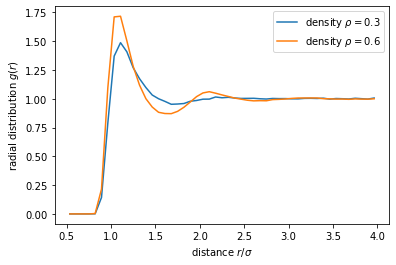

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

print("density 0.3:")
print("mean energy per particle {}\nerr energy per particle {}".format(
    result_low_dens["energy_mean"], result_low_dens["energy_err"]))
print("pressure {}\nerr pressure {}".format(
    result_low_dens["pressure_mean"], result_low_dens["pressure_err"]))
print("density 0.6:")
print("mean energy per particle {}\nerr energy per particle {}".format(
    result_hi_dens["energy_mean"], result_hi_dens["energy_err"]))
print("pressure {}\nerr pressure {}".format(
    result_hi_dens["pressure_mean"], result_hi_dens["pressure_err"]))

plt.plot(result_low_dens["rdf_bin_centers"], result_low_dens["rdf_mean"], label=r"density $\rho=0.3$")
plt.plot(result_hi_dens["rdf_bin_centers"], result_hi_dens["rdf_mean"], label=r"density $\rho=0.6$")
plt.xlabel(r"distance $r/\sigma$")
plt.ylabel(r"radial distribution $g(r)$")
plt.legend(loc="best")
plt.show()